This notebook creates a simple logistic regression model to distinguish between two close-packed configurations of spheres, FCC ($cF4-\text{Cu}$) and HCP ($hP2-\text{Mg}$). We also compare them to the Steinhardt order parameter $Q_6$.

In [1]:
import collections

import freud
import matplotlib, matplotlib.pyplot as pp
%matplotlib inline
import numpy as np
import pythia
import scipy as sp, scipy.stats
import sklearn, sklearn.model_selection, sklearn.linear_model

We define some functions to deal with periodic boundary conditions and replication of unit cells.

In [2]:
FakeBox = collections.namedtuple('FakeBox', ['Lx', 'Ly', 'Lz', 'xy', 'xz', 'yz'])
FileData = collections.namedtuple('FileData', ['positions', 'box'])

def box_to_matrix(box):
    """Converts a box tuple (in [lx, ly, lz, xy, xz, yz] order with HOOMD
    meanings) into a box matrix"""
    (lx, ly, lz, xy, xz, yz) = box
    return np.array([[lx, xy*ly, xz*lz],
                     [0,     ly, yz*lz],
                     [0,      0,    lz]], dtype=np.float64)

def make_fractions(box, positions):
    """Converts a box tuple and positions array into a set of box
    fractions for each position"""
    box = list(box)
    if box[2] == 0:
        box[2] == 1
    boxmat = box_to_matrix(box)
    invbox = np.linalg.inv(boxmat)

    return np.dot(invbox, positions.T).T + .5

def fractions_to_coordinates(box, fractions):
    """Converts a box tuple and fraction array into a position for each
    given fraction"""
    boxmat = box_to_matrix(box)
    fractions = fractions - .5

    coordinates = np.sum(
        fractions[:, np.newaxis, :]*boxmat[np.newaxis, :, :], axis=2)
    return coordinates

def replicate_upto(N_target, positions, box):
    nbase = int(np.floor((N_target/len(positions))**(1/3)))
    start_boxdims = np.array(box[:3])
    ns = [nbase, nbase, nbase]
    while len(positions)*np.product(ns) < N_target:
        repl_boxdims = start_boxdims*ns
        ns[np.argmin(repl_boxdims)] += 1
    (nx, ny, nz) = ns
    
    frac_positions = np.tile(make_fractions(box, positions), (nx, ny, nz, 1, 1)).astype(np.float32) 
    frac_positions[:, ..., 0] += np.arange(nx)[:, np.newaxis, np.newaxis, np.newaxis]               
    frac_positions[:, ..., 1] += np.arange(ny)[np.newaxis, :, np.newaxis, np.newaxis]               
    frac_positions[:, ..., 2] += np.arange(nz)[np.newaxis, np.newaxis, :, np.newaxis]               
                                                                                                    
    frac_positions = frac_positions.reshape((-1, 3))                                                
    frac_positions /= (nx, ny, nz)                                                                  
    frac_positions -= np.floor(frac_positions)                                                      
                                                                                                    
    box = list(box)                                                                                 
    box[0] *= nx                                                                                    
    box[1] *= ny                                                                                    
    box[2] *= nz               
                                                                                                        
    new_positions = fractions_to_coordinates(box, frac_positions).astype(np.float32)
                                                                                                    
    return FileData(new_positions, tuple(box))

We create the unit cells:

In [3]:
fancy_structure_names = dict(
    fcc='$cF4$-Cu',
    hcp='$hP2$-Mg',
)

fcc_positions = np.array([
    (1, 1, 1),
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1)
], dtype=np.float32)*np.sqrt(2)/2
fcc_box = FakeBox(np.sqrt(2), np.sqrt(2), np.sqrt(2), 0, 0, 0)
fcc = FileData(fcc_positions, fcc_box)

hcp_positions = np.array([
    (0, 0, 0),
    (.5, .5/np.sqrt(3), np.sqrt(2./3))
])
hcp_box = FakeBox(1, np.sqrt(3)/2, np.sqrt(8/3), np.sqrt(1./3), 0, 0)
hcp = FileData(hcp_positions, hcp_box)

structures = dict(fcc=fcc, hcp=hcp)

def get_thermal_system(name):
    system = replicate_upto(4000, *structures[name])
    system.positions[:] += np.random.normal(scale=5e-2, size=system.positions.shape)
    fbox = freud.box.Box(*system.box)
    fbox.wrap(system.positions)
    return system

This cell computes a histogram of the Steinhardt order parameter $Q_6$ for each type of particle.

/usr/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


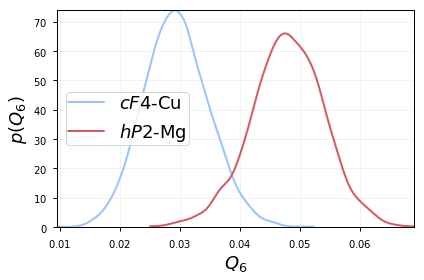

In [4]:
for name in structures:
    system = get_thermal_system(name)
    
    fbox = freud.box.Box(*system.box)
    Ql = freud.order.LocalQlNear(fbox, 3, 6, 12)
    Ql.compute(system.positions)
    Q6 = Ql.Ql.copy()
    
#     rdf = freud.density.RDF(3, .01)
#     rdf.compute(fbox, system.positions, system.positions)
#     pp.plot(rdf.R, rdf.RDF)
    
    kde = sp.stats.gaussian_kde(Q6)
    xs = np.linspace(np.min(Q6), np.max(Q6), 1024)
    ys = kde(xs)
    pp.plot(xs, ys, label=fancy_structure_names[name])

pp.xlabel('$Q_6$')
pp.ylabel('$p(Q_6)$')
pp.legend()
pp.savefig('/tmp/fcc_hcp_q6_histogram.svg')

This cell computes a histogram of an order parameter created using logistic regression via [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

/usr/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


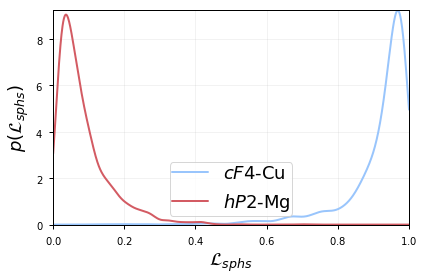

In [5]:
all_inputs = []
for name in sorted(structures):
    system = get_thermal_system(name)
    
    sphs = pythia.spherical_harmonics.abs_neighbor_average(
        system.box, system.positions, neigh_max=12, lmax=6, negative_m=False)
    all_inputs.append(sphs)
    
all_outputs = np.concatenate([np.full(len(inp), i) for (i, inp) in enumerate(all_inputs)])
all_inputs = np.concatenate(all_inputs, axis=0)

(trainIns, testIns, trainOuts, testOuts) = sklearn.model_selection.train_test_split(
    all_inputs, all_outputs, test_size=.5, random_state=1)

lr = sklearn.linear_model.LogisticRegression()
lr.fit(trainIns, trainOuts)

tf = lr.predict_proba(testIns)

for (i, name) in enumerate(sorted(structures)):
    filt = testOuts == i
    op = tf[filt, 0]
    kde = sp.stats.gaussian_kde(op)
    xs = np.linspace(0, 1, 1024)
    ys = kde(xs)
    pp.plot(xs, ys, label=fancy_structure_names[name])

pp.legend()
pp.xlabel(r'$\mathcal{L}_{sphs}$')
pp.ylabel(r'$p(\mathcal{L}_{sphs})$')
pp.savefig('/tmp/fcc_hcp_ameanLR_histogram.svg')
    